In [9]:
import sys
from pathlib import Path
import pandas as pd
from datetime import datetime, timedelta
import logging

# COMPREHENSIVE LOGGING SUPPRESSION - Set this BEFORE any imports
logging.disable(logging.INFO)  # This disables all INFO and below messages

# Add the project root to Python path
project_root = Path.cwd().parent  # Adjust this path to your project root
sys.path.insert(0, str(project_root))

from src.data.storage.database import get_db_manager
from src.dashboard.services.data_service import get_data_service

In [27]:
import datetime
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.ticker import FixedLocator, FixedFormatter
import os

# Load Data

In [19]:
def get_all_stock_data_and_info():
    """
    Get all stock data and stock info in DataFrames.
    
    Returns:
        tuple: (stock_data_df, stock_info_df, symbols_list)
    """
    try:
        # Initialize services
        db_manager = get_db_manager()
        data_service = get_data_service()
        
        # Get all available symbols
        symbols = data_service.get_available_symbols()
        print(f"Found {len(symbols)} symbols with data")
        
        # Get stock info for all symbols
        stock_info_list = []
        for symbol in symbols:
            stock_info = db_manager.get_stock_info(symbol)
            if stock_info:
                stock_info_list.append(stock_info)
        
        # Create stock info DataFrame
        stock_info_df = pd.DataFrame(stock_info_list)
        if not stock_info_df.empty:
            print(f"Retrieved stock info for {len(stock_info_df)} symbols")
        
        # Get market data for all symbols (last 30 days for efficiency)
        all_market_data = []
        for symbol in symbols:
            try:
                # Get last 30 days of data for each symbol
                #df = data_service.get_market_data(symbol, days=30, hourly=True)
                df = data_service.get_all_market_data(symbol, hourly=True)
                if not df.empty:
                    all_market_data.append(df)
                    #print(f"Retrieved {len(df)} records for {symbol}")
            except Exception as e:
                print(f"Error getting data for {symbol}: {e}")
        
        # Combine all market data
        if all_market_data:
            stock_data_df = pd.concat(all_market_data, ignore_index=True)
            print(f"Combined market data: {len(stock_data_df)} total records")
        else:
            stock_data_df = pd.DataFrame()
            print("No market data retrieved")
        
        return stock_data_df, stock_info_df, symbols
        
    except Exception as e:
        print(f"Error: {e}")
        return pd.DataFrame(), pd.DataFrame(), []


In [20]:
# Usage example:
print("Fetching all stock data and info...")
stock_data_df, stock_info_df, symbols = get_all_stock_data_and_info()

Fetching all stock data and info...
Found 1057 symbols with data
Retrieved stock info for 1057 symbols
Combined market data: 1833341 total records


In [21]:
# Display results
print("\n" + "="*50)
print("STOCK DATA SUMMARY:")
print("="*50)
if not stock_data_df.empty:
    print(f"Market data shape: {stock_data_df.shape}")
    print(f"Date range: {stock_data_df['timestamp'].min()} to {stock_data_df['timestamp'].max()}")
    print(f"Symbols in data: {stock_data_df['symbol'].nunique()}")
    #print("\nSample market data:")
    #print(stock_data_df.head())
else:
    print("No market data available")

print("\n" + "="*50)
print("STOCK INFO SUMMARY:")
print("="*50)
if not stock_info_df.empty:
    print(f"Stock info shape: {stock_info_df.shape}")
    print(f"Available sectors: {stock_info_df['sector'].nunique()}")
    print(f"Available industries: {stock_info_df['industry'].nunique()}")
    #print("\nSample stock info:")
    #print(stock_info_df.head())
else:
    print("No stock info available")

print(f"\nTotal symbols found: {len(symbols)}")


STOCK DATA SUMMARY:
Market data shape: (1833341, 8)
Date range: 2024-08-02 08:00:00 to 2025-08-01 14:00:00
Symbols in data: 1057

STOCK INFO SUMMARY:
Stock info shape: (1057, 12)
Available sectors: 11
Available industries: 131

Total symbols found: 1057


# Analysis

In [24]:
# Visualization basics
%matplotlib inline

fig_path = r'D:\PythonProjects\MLTrading\notebooks\fig'  


def pred_color_presentation(c):
    custom_palette_presentation = {
        'midnight-blue': '#191970',
        'forest-green': '#228B22',
        'muted-gold': '#B8860B',
        'light-gray': '#D3D3D3',
        'sea-green': '#2E8B57',
        'teal-green': '#008080',
        'highlight': '#C19A6B',
        'black': '#000000',
        'color1':'#dfdfdf',
        'color2':'#dfb834',
        'color3':'#f1f6db',
        'color4':'#649e92',
        'color5':'#a13d61',
    }
    return custom_palette_presentation.get(c, "Invalid color name")

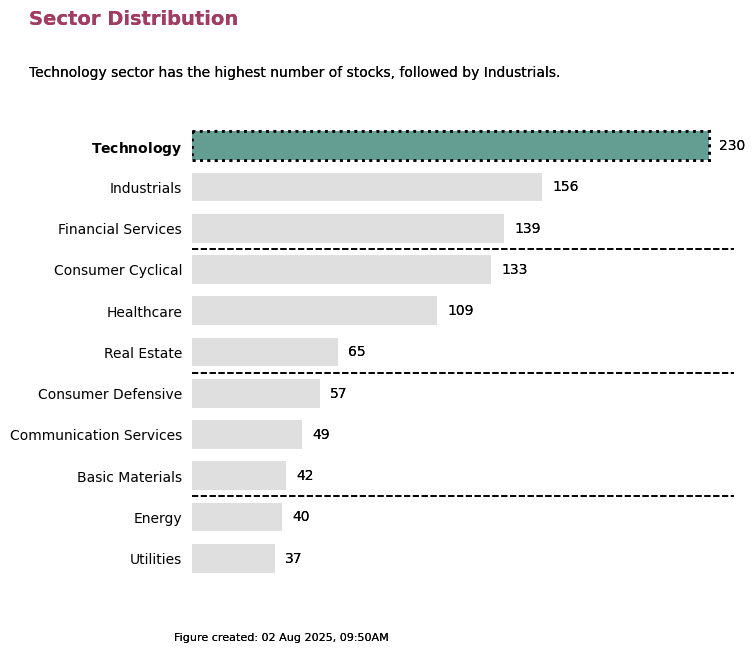

In [28]:
# Get current date and time
now = datetime.datetime.now()
formatted_date_time = now.strftime("%d %b %Y, %I:%M%p") 

# Prepare unique industry counts
temp_df = stock_info_df[['symbol', 'sector']].drop_duplicates()
sector_counts = temp_df['sector'].value_counts().sort_values(ascending=False)

# Identify the industry with the highest count
max_index = sector_counts.idxmax()

# Define colors based on the highest count
colors = [pred_color_presentation('color1') if sector != max_index else pred_color_presentation('color4') for sector in sector_counts.index]

# Create a horizontal bar chart with highest at the top
ax = sector_counts.plot(kind='barh', figsize=(7, 6), width=0.7, color=colors)

# Reverse the order so the highest value appears at the top
ax.invert_yaxis()

# Keep y-labels but remove y-ticks
ax.set_yticks(range(len(sector_counts)))

# Make y-labels and bold the one for max industry
yticklabels = []
for sector in sector_counts.index:
    if sector == max_index:
        yticklabels.append(f"$\\bf{{{sector}}}$")
    else:
        yticklabels.append(sector)
ax.set_yticklabels(yticklabels, fontsize=10)

ax.tick_params(left=False)

# Add margin space between labels and bars
ax.margins(y=0.1)

# Add horizontal lines to group pairs of three
for i in range(3, len(sector_counts), 3):
    ax.axhline(y=i - 0.5, color='black', linestyle='dashed', linewidth=1.2)

# Customize the chart
ax.set_xlabel('Number of Stocks')
ax.set_ylabel('')
ax.set_xticklabels([])  
ax.xaxis.set_visible(False)  
ax.grid(axis='x', linestyle='none')
ax.grid(axis='y', linestyle='none')

# Remove unnecessary spines
for spine in ['right', 'top', 'bottom', 'left']:
    ax.spines[spine].set_visible(False)

# Get bar positions for count labels
bar_containers = ax.containers  
bar_y_positions = [rect.get_y() + rect.get_height() / 2 for rect in bar_containers[0]]

# Add count labels with bold for the highest count
for count, y_pos, industry in zip(sector_counts, bar_y_positions, sector_counts.index):
    fontweight = 'bold' if sector == max_index else 'normal'
    ax.text(
        count + max(sector_counts) * 0.02,
        y_pos,
        str(count),
        va='center',
        ha='left',
        fontsize=10,
        fontweight=fontweight
    )

# Add a dotted border around the bar with the highest count
for rect, sector in zip(bar_containers[0], sector_counts.index):
    if sector == max_index:
        x = rect.get_x()
        y = rect.get_y()
        width = rect.get_width()
        height = rect.get_height()

        dotted_rect = patches.Rectangle(
            (x, y),
            width,
            height,
            linewidth=2,
            edgecolor='black',
            facecolor='none',
            linestyle='dotted'
        )
        ax.add_patch(dotted_rect)
        break

# Add annotation for the highest industry
plt.annotate(
    'Sector Distribution', 
    xy=(-0.3, 1.2), 
    xycoords='axes fraction', 
    fontsize=14, 
    fontweight='bold',
    ha='left', 
    va='bottom',
    color=pred_color_presentation('color5')
)

plt.annotate(
    f'{sector_counts.index[0]} sector has the highest number of stocks, followed by {sector_counts.index[1]}.', 
    xy=(-0.3, 1.09), 
    xycoords='axes fraction', 
    fontsize=10, 
    ha='left', 
    va='bottom',
    color='black'
)

# Add footnote with date and time
plt.figtext(
    0.1,  
    0.01,  
    f"Figure created: {formatted_date_time}",
    horizontalalignment='left',
    verticalalignment='bottom',
    fontsize=8,
    color='black'
)

# Save and show the plot
fig_name = f'sector_distribution.jpg'
plt.savefig(os.path.join(fig_path, fig_name), bbox_inches='tight')
plt.show()